# Reading saved boxes with gather

In today's class we will show how to use the saved information in `21cmFAST` cached folders. Both the coeval and lightcone classes will save a lot of data if you run them with write=True, and you can use these functions to output that data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools

import h5py
import numpy as np

In [2]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.3


Clear the cache so that we get the same results for the notebook every time (don't worry about this for now). Also, set the default output directory to `_cache/`:

In [3]:
if not os.path.exists('_cache'):
    os.mkdir('_cache')
    
p21c.config['direc'] = '_cache'
cache_tools.clear_cache(direc="_cache")

2020-12-01 16:13:05,820 | INFO | Removing BrightnessTemp_8bf8e9863740192cd94135c685170a62_r1978.h5
2020-12-01 16:13:05,829 | INFO | Removing PerturbedField_c3c6247dffd9586f8f48ff47d92ef6b8_r1978.h5
2020-12-01 16:13:05,838 | INFO | Removing PerturbedField_e69caa4e15c740338ba49b098be897fd_r1978.h5
2020-12-01 16:13:05,850 | INFO | Removing BrightnessTemp_d22fb19bd0bc0d752edc01edea832ea8_r1978.h5
2020-12-01 16:13:05,862 | INFO | Removing IonizedBox_1af6a195098191fe3b771fe56e241ad4_r1978.h5
2020-12-01 16:13:05,872 | INFO | Removing IonizedBox_f986e27224fac804485ea588cd3cacdb_r1978.h5
2020-12-01 16:13:05,880 | INFO | Removing PerturbedField_cd92636fc2cec183608083c3c04c5ccf_r1978.h5
2020-12-01 16:13:05,886 | INFO | Removing PerturbedField_0c5adf72cdf30a41933f55811a9fa93a_r1978.h5
2020-12-01 16:13:05,897 | INFO | Removing BrightnessTemp_674971573ca560e1bc48a2d687d942c8_r1978.h5
2020-12-01 16:13:05,909 | INFO | Removing IonizedBox_8e186aac12f489267597fd04ae0c140c_r1978.h5
2020-12-01 16:13:05,92

## Create an example box

We first run a coeval box and lightcone to have something to read later

In [4]:
coeval = p21c.run_coeval(
    redshift = 25.0,
    user_params = {"HII_DIM": 30, "BOX_LEN": 30},
    random_seed=1978,
    write=True
)

lightcone = p21c.run_lightcone(
    redshift = 25.0,
    max_redshift = 35.0,
    user_params = {"HII_DIM": 30, "BOX_LEN": 30},
    random_seed=1978,
    lightcone_quantities=("brightness_temp", 'density'),
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    write=True
)

2020-12-01 16:13:09,658 | INFO | Existing init_boxes found and read in (seed=1978).
2020-12-01 16:13:09,693 | INFO | Existing z=25.0 perturb_field boxes found and read in (seed=1978).
2020-12-01 16:13:14,042 | INFO | Existing z=25.0 perturb_field boxes found and read in (seed=1978).
2020-12-01 16:13:14,071 | INFO | Existing z=25.0 ionized boxes found and read in (seed=1978).
2020-12-01 16:13:14,094 | INFO | Existing brightness_temp box found and read in (seed=1978).


In [5]:
#you can uncomment this to print the names of the boxes that have been created
#print(lightcone.cache_files)

## Example for Coeval

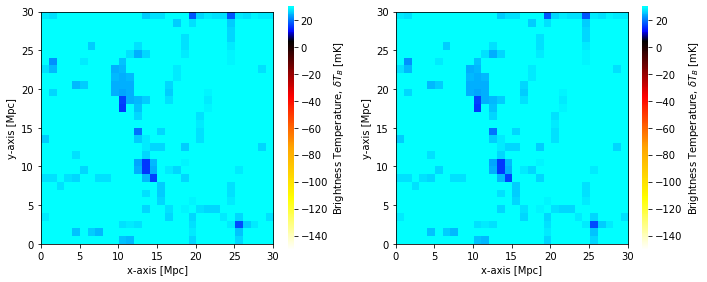

In [6]:
T21cache = coeval.get_cached_data(redshift=25.1, kind='brightness_temp', load_data=True); 
#this reads the cached data of some kind at the z closest to redshift (which will be 25.0 for us)
#kinds that can be read are "perturb_field", "ionized_box", "spin_temp", and "brightness_temp" at z, plus "init"

fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coeval, ax=ax[0], fig=fig)
plotting.coeval_sliceplot(T21cache, ax=ax[1], fig=fig)
plt.tight_layout() 
#they are identical

In [7]:
#you can also create a file with all the data together.
folderdata = '_cache'
filename = "gathered_coeval_data.h5"

coeval.gather(
        fname=filename,
        kinds=("perturb_field", "init"),
        direc=folderdata,
        )
#this gathers all the cached data, spread amongst many files, into a single one (fname), that can be read in any machine
#note that this duplicates a lot of data, so it's expensive, and cannot be run if the file already exists

RuntimeError: Unable to create link (name already exists)

<KeysViewHDF5 ['cache']>
<KeysViewHDF5 ['init', 'perturb_field']>
<KeysViewHDF5 ['z25.00']>
<KeysViewHDF5 ['z0.00']>


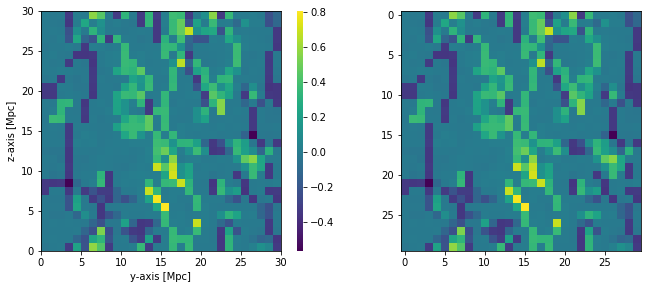

In [8]:
with h5py.File(folderdata+"/"+filename, "r") as file:
    print(file.keys())    
    print(file["cache"].keys()) #this will give you the kinds that were saved    
    print(file["cache"]["perturb_field"].keys()) #this will give you the z for this kind
    print(file["cache"]["init"].keys()) #ICs appear as z=0 as they do not depend on z
    delta_pert= list(file["cache"]["perturb_field"]["z25.00"]["density"])


from scipy import ndimage
    
fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coeval, ax=ax[0], fig=fig, kind="density", slice_axis=0);
rotated_delta = ndimage.rotate(delta_pert[0], 90) #the coeval boxes are rotated w.r.t. numpy array
im1=ax[1].imshow(rotated_delta, origin="upper")
plt.tight_layout() #identical!

## Example for Lightcone

In [9]:
filenameLC = "gathered_lightcone_data.h5"

lightcone.gather(
        fname=filenameLC,
        kinds=("brightness_temp", "init"),
        direc=folderdata,
        )
#here we save brightness_temp instead, now there'll be more than one z since it's a LC.

RuntimeError: Unable to create link (name already exists)

['z25.00', 'z25.52', 'z26.05', 'z26.59', 'z27.14', 'z27.71', 'z28.28', 'z28.87', 'z29.46', 'z30.07', 'z30.69', 'z31.33', 'z31.97', 'z32.63', 'z33.31', 'z33.99', 'z34.69', 'z35.41']


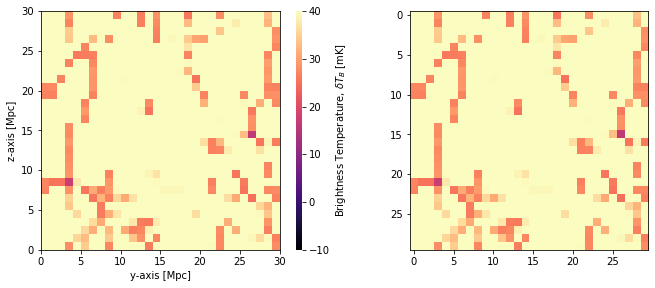

In [10]:
with h5py.File(folderdata+"/"+filenameLC, "r") as file:
    zlistkeys = list( file["cache"]["brightness_temp"].keys()) #this will give you the z saved, more than one now.
    print(zlistkeys)
    T21saved= list(file["cache"]["brightness_temp"][zlistkeys[0]]['brightness_temp'])


T21minplot=-10.0
T21maxplot=40.0

#we compare the T21 box we've read at zfinal with the coeval box we've run.    
fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coeval, ax=ax[0], fig=fig, kind="brightness_temp", slice_axis=0,
                         vmin=T21minplot, vmax=T21maxplot, cmap = "magma");
rotated_T21 = ndimage.rotate(T21saved[0], 90)
ax[1].imshow(rotated_T21, origin="upper",
                         vmin=T21minplot, vmax=T21maxplot, cmap = "magma")
plt.tight_layout() #identical too!

And you can also access any intermediate z that has been saved. As an example, let's do z~30:

2020-12-01 16:14:17,136 | INFO | Existing init_boxes found and read in (seed=1978).


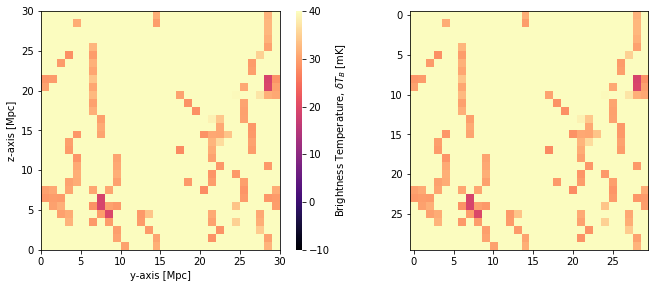

In [11]:
z30 = zlistkeys[10] #the closest to 30
#To compare against something, let us run a coeval, but given the exact z30 it will read inputs and be fast
zz=float(z30[1:])
coevalz30 = p21c.run_coeval(
    redshift = zz,
    user_params = {"HII_DIM": 30, "BOX_LEN": 30},
    random_seed=1978,
    write=False
)


#also read the LC-saved T21 box at z=30
with h5py.File(folderdata+"/"+filenameLC, "r") as file:
    T21savedz30= list(file["cache"]["brightness_temp"][z30]['brightness_temp'])


#we compare the T21 box we've read at zfinal with the coeval box we've run.    
fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coevalz30, ax=ax[0], fig=fig, kind="brightness_temp", slice_axis=0,
                         vmin=T21minplot, vmax=T21maxplot, cmap = "magma");
rotated_T21 = ndimage.rotate(T21savedz30[0], 90)
ax[1].imshow(rotated_T21, origin="upper",
                         vmin=T21minplot, vmax=T21maxplot, cmap = "magma")
plt.tight_layout() #identical too!

And here's how it works for the ionization fraction at an intermediate z if you only want to load one file

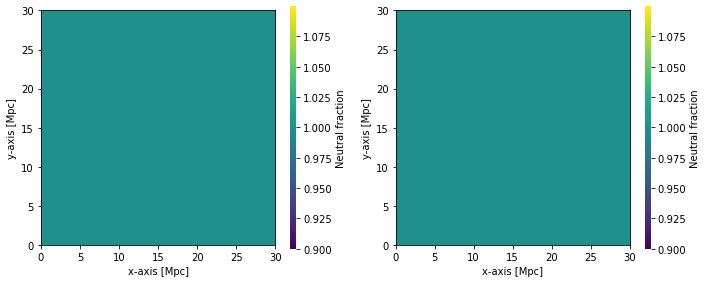

In [12]:
xHcache = lightcone.get_cached_data(redshift=zz, kind='ionized_box', load_data=True); 
#this works pretty much identical to the coeval, but now it has information about intermediate zs

fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coevalz30, ax=ax[0], fig=fig, kind='xH_box', cmap = "viridis")
plotting.coeval_sliceplot(xHcache, ax=ax[1], fig=fig, kind='xH_box', cmap = "viridis")
plt.tight_layout() 
#they are identically ~zero because no ionization has occured.